# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/alessandrobertelli/Desktop/University/KTH/mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 15, 14, 3, 28, 176916)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-15 14:03:28,181 INFO: Initializing external client
2025-11-15 14:03:28,182 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-15 14:03:30,503 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-15 14:03:33,528 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1299605


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

models = mr.get_models("air_quality_xgboost_model")
latest_model_v = max([m.version for m in models])
print("Latest version of the models:" ,latest_model_v)

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=latest_model_v,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Latest version of the models: 6
2025-11-15 14:03:50,817 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/546695 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/100899 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26711 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='5.000368E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=2,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.86s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,relative_humidity_2m_mean,surface_pressure_mean,city
0,2025-11-20 00:00:00+00:00,16.549999,0.0,13.324863,218.418091,50.0,1007.112915,rome
1,2025-11-21 00:00:00+00:00,10.750000,0.3,8.473393,347.735229,90.0,1008.133728,rome
2,2025-11-16 00:00:00+00:00,21.150000,0.0,13.004921,175.236450,59.0,1010.458618,rome
3,2025-11-18 00:00:00+00:00,17.150000,0.0,3.976330,5.194350,75.0,1007.618774,rome
4,2025-11-17 00:00:00+00:00,19.400000,0.2,21.638964,225.673950,65.0,1005.454834,rome
5,2025-11-19 00:00:00+00:00,14.150000,0.1,2.741678,203.198624,80.0,1006.285034,rome


In [8]:
# Retrieve recent PM2.5 entries for constructing lag variables
aq_fg = fs.get_feature_group(name='air_quality', version=1)

# Pull PM2.5 data from the past 3 days
three_day_from_today = today - datetime.timedelta(days=3)
pm25_window = aq_fg.filter(aq_fg.date >= three_day_from_today).read()
pm25_window = pm25_window.sort_values('date')

print("Recent PM2.5 measurements (3-day window):")
print(pm25_window[['date', 'pm25']])

# Prepare lagged PM2.5 values
pm_series = pm25_window['pm25'].values
n_vals = len(pm_series)

# Use match-case to select how to compute the lag features
match n_vals:
    case n if n >= 3:
        pm25_lagged1 = pm_series[-1]
        pm25_lagged2 = pm_series[-2]
        pm25_lagged3 = pm_series[-3]
    case 2:
        pm25_lagged1 = pm_series[-1]
        pm25_lagged2 = pm_series[-2]
        pm25_lagged3 = pm_series[-2]
    case 1:
        pm25_lagged1 = pm_series[-1]
        pm25_lagged2 = pm_series[-1]
        pm25_lagged3 = pm_series[-1]
    case _:
        pm25_lagged1 = pm25_lagged2 = pm25_lagged3 = 25.0
        print("Note: No recent PM2.5 records found, using fallback value 25.0")

print("\nComputed lag variables:")
print(f"  pm25_lagged1 (yesterday): {pm25_lagged1}")
print(f"  pm25_lagged2 (2 days ago): {pm25_lagged2}")
print(f"  pm25_lagged3 (3 days ago): {pm25_lagged3}")

# Attach lag values to batch_data
batch_data['pm25_lagged1'] = pm25_lagged1
batch_data['pm25_lagged2'] = pm25_lagged2
batch_data['pm25_lagged3'] = pm25_lagged3

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.88s) 
Recent PM2.5 measurements (3-day window):
                       date  pm25
0 2025-11-13 00:00:00+00:00  68.0
1 2025-11-15 00:00:00+00:00  68.0

Computed lag variables:
  pm25_lagged1 (yesterday): 68.0
  pm25_lagged2 (2 days ago): 68.0
  pm25_lagged3 (3 days ago): 68.0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [9]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant',
                'relative_humidity_2m_mean','surface_pressure_mean','pm25_lagged1','pm25_lagged2', 'pm25_lagged3']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,relative_humidity_2m_mean,surface_pressure_mean,city,pm25_lagged1,pm25_lagged2,pm25_lagged3,predicted_pm25
0,2025-11-20 00:00:00+00:00,16.549999,0.0,13.324863,218.418091,50.0,1007.112915,rome,68.0,68.0,68.0,61.469746
1,2025-11-21 00:00:00+00:00,10.750000,0.3,8.473393,347.735229,90.0,1008.133728,rome,68.0,68.0,68.0,63.935524
2,2025-11-16 00:00:00+00:00,21.150000,0.0,13.004921,175.236450,59.0,1010.458618,rome,68.0,68.0,68.0,63.926903
3,2025-11-18 00:00:00+00:00,17.150000,0.0,3.976330,5.194350,75.0,1007.618774,rome,68.0,68.0,68.0,59.250992
4,2025-11-17 00:00:00+00:00,19.400000,0.2,21.638964,225.673950,65.0,1005.454834,rome,68.0,68.0,68.0,55.468693
5,2025-11-19 00:00:00+00:00,14.150000,0.1,2.741678,203.198624,80.0,1006.285034,rome,68.0,68.0,68.0,62.381145


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   relative_humidity_2m_mean    6 non-null      float32                
 6   surface_pressure_mean        6 non-null      float32                
 7   city                         6 non-null      object                 
 8   pm25_lagged1                 6 non-null      float32                
 9   pm25_lagged2                 6 non-null      float32                
 10  pm25_l

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [11]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,relative_humidity_2m_mean,surface_pressure_mean,city,pm25_lagged1,pm25_lagged2,pm25_lagged3,predicted_pm25,street,country,days_before_forecast_day
2,2025-11-16 00:00:00+00:00,21.150000,0.0,13.004921,175.236450,59.0,1010.458618,rome,68.0,68.0,68.0,63.926903,rome,italy,3
4,2025-11-17 00:00:00+00:00,19.400000,0.2,21.638964,225.673950,65.0,1005.454834,rome,68.0,68.0,68.0,55.468693,rome,italy,5
3,2025-11-18 00:00:00+00:00,17.150000,0.0,3.976330,5.194350,75.0,1007.618774,rome,68.0,68.0,68.0,59.250992,rome,italy,4
5,2025-11-19 00:00:00+00:00,14.150000,0.1,2.741678,203.198624,80.0,1006.285034,rome,68.0,68.0,68.0,62.381145,rome,italy,6
0,2025-11-20 00:00:00+00:00,16.549999,0.0,13.324863,218.418091,50.0,1007.112915,rome,68.0,68.0,68.0,61.469746,rome,italy,1
1,2025-11-21 00:00:00+00:00,10.750000,0.3,8.473393,347.735229,90.0,1008.133728,rome,68.0,68.0,68.0,63.935524,rome,italy,2


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 2 to 1
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   relative_humidity_2m_mean    6 non-null      float32                
 6   surface_pressure_mean        6 non-null      float32                
 7   city                         6 non-null      object                 
 8   pm25_lagged1                 6 non-null      float32                
 9   pm25_lagged2                 6 non-null      float32                
 10  pm25_lagged

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-15 14:04:12,620 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



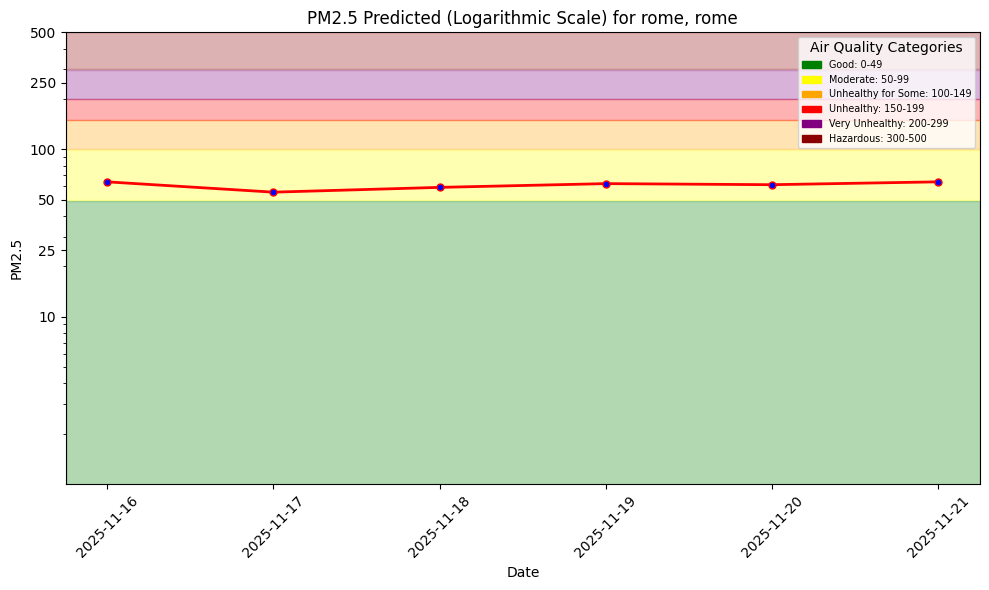

In [13]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [14]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [15]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1299605/fs/1287235/fg/1718625


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1299605/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-15 14:04:41,975 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 14:04:45,786 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 14:06:27,645 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 14:06:28,373 INFO: Waiting for log aggregation to finish.
2025-11-15 14:06:43,536 INFO: Execution finished successfully.


(Job('aq_predictions_2_offline_fg_materialization', 'SPARK'), None)

In [16]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.64s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,relative_humidity_2m_mean,surface_pressure_mean,city,pm25_lagged1,pm25_lagged2,pm25_lagged3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-20 00:00:00+00:00,16.549999,0.0,13.324863,218.418091,50.0,1007.112915,rome,68.0,68.0,68.0,61.469746,rome,italy,1


In [17]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.46s) 


,date,pm25,country,city,street,url
0,2018-07-30 00:00:00+00:00,63.0,italy,rome,rome,https://api.waqi.info/feed/@9352
1,2018-08-19 00:00:00+00:00,30.0,italy,rome,rome,https://api.waqi.info/feed/@9352
2,2021-07-28 00:00:00+00:00,46.0,italy,rome,rome,https://api.waqi.info/feed/@9352
3,2024-06-11 00:00:00+00:00,34.0,italy,rome,rome,https://api.waqi.info/feed/@9352
4,2024-03-30 00:00:00+00:00,63.0,italy,rome,rome,https://api.waqi.info/feed/@9352
...,...,...,...,...,...,...
3996,2016-01-02 00:00:00+00:00,89.0,italy,rome,rome,https://api.waqi.info/feed/@9352
3997,2017-01-13 00:00:00+00:00,17.0,italy,rome,rome,https://api.waqi.info/feed/@9352
3998,2020-12-14 00:00:00+00:00,59.0,italy,rome,rome,https://api.waqi.info/feed/@9352
3999,2016-12-06 00:00:00+00:00,119.0,italy,rome,rome,https://api.waqi.info/feed/@9352


In [18]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (10.53s) 
2025-11-15 14:07:01,932 WARNING: DeprecationWarning: Out of bound index found. This was previously ignored when the indexing result contained no elements. In the future the index error will be raised. This error occurs either due to an empty slice, or if an array has zero elements even before indexing.
(Use `warnings.simplefilter('error')` to turn this DeprecationWarning into an error and get more details on the invalid index.)



Uploading Dataframe: 0.00% | | Rows 0/0 | Elapsed Time: 00:00 | Remaining Time: 


Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1299605/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-15 14:07:24,604 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 14:07:28,347 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 14:08:28,951 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 14:08:30,113 INFO: Waiting for log aggregation to finish.
2025-11-15 14:08:40,486 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,relative_humidity_2m_mean,surface_pressure_mean,city,pm25,street,country,pm25_lagged1,pm25_lagged2,pm25_lagged3,predicted_pm25,days_before_forecast_day


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

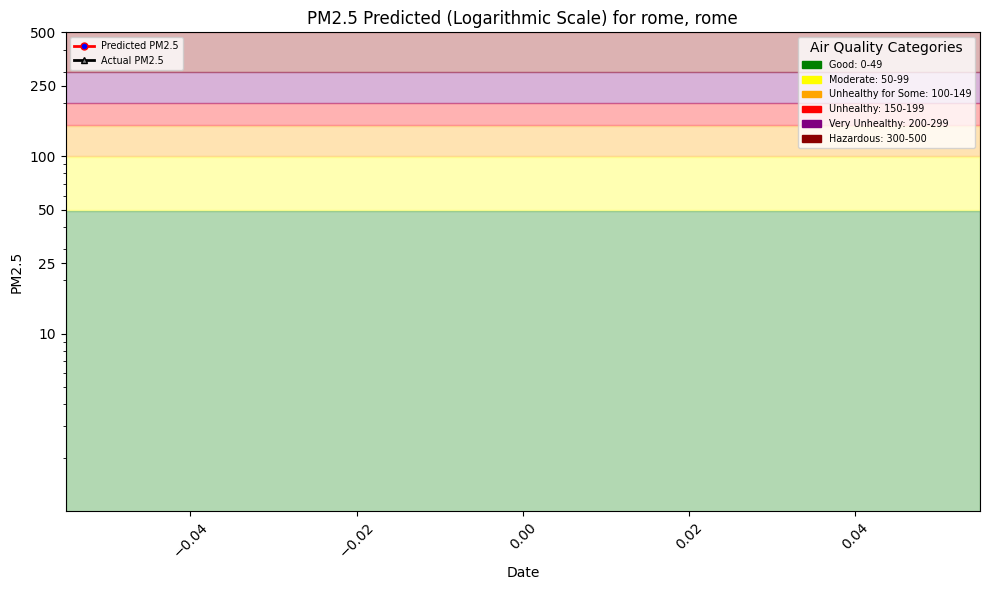

In [19]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [20]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/alessandrobertelli/Desktop/University/KTH/mlfs-book/docs/air-quality/assets/img/pm25_forecast…

Uploading /Users/alessandrobertelli/Desktop/University/KTH/mlfs-book/docs/air-quality/assets/img/pm25_hindcast…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1299605/settings/fb/path/Resources/airquality


---